# Proper GPs
Much here changed with the help of the `Flux Experimentation.ipynb` notebook. I'll try to make pretty, functional GPs here.

In [159]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

In [160]:
zero_mean() = x -> zeros(size(x))
constant_mean(m) = x -> zeros(size(x)) .+ m
rbf(l, σ_f) = 
    (x₁, x₂) -> σ_f.^2 .* exp.(- (x₁ .- x₂').^2 ./ l.^2)
noise(σ_n) = 
    (x₁, x₂) -> (x₁ .== x₂') * σ_n[1]^2
struct GP
    μ
    k
end
GP(k) = GP(zero_mean(), k)

GP

In [161]:
import Base: +, -
function +(gp1::GP, gp2::GP)
    μ(x) = gp1.μ(x) .+ gp2.μ(x)
    k(x1, x2) = gp1.k(x1, x2) .+ gp2.k(x1, x2)
    return GP(μ, k)
end

+ (generic function with 208 methods)

In [162]:
f = GP(constant_mean([5.]), rbf([2.], [0.5]))
ϵ = GP(noise([.1]))
y = f + ϵ

GP(getfield(Main, Symbol("#μ#155")){GP,GP}(GP(getfield(Main, Symbol("##149#150")){Array{Float64,1}}([5.0]), getfield(Main, Symbol("##151#152")){Array{Float64,1},Array{Float64,1}}([2.0], [0.5])), GP(getfield(Main, Symbol("##147#148"))(), getfield(Main, Symbol("##153#154")){Array{Float64,1}}([0.1]))), getfield(Main, Symbol("#k#156")){GP,GP}(GP(getfield(Main, Symbol("##149#150")){Array{Float64,1}}([5.0]), getfield(Main, Symbol("##151#152")){Array{Float64,1},Array{Float64,1}}([2.0], [0.5])), GP(getfield(Main, Symbol("##147#148"))(), getfield(Main, Symbol("##153#154")){Array{Float64,1}}([0.1]))))

## Prior sample

In [163]:
prior(gp, X) = MultivariateNormal(gp.μ(X), gp.k(X, X) + 1e-6I)

prior (generic function with 1 method)

In [164]:
Xs = 0:0.01:10
prior_distribution = prior(f, Xs)

FullNormal(
dim: 1001
μ: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Σ: [0.250001 0.249994 … 3.64991e-12 3.47199e-12; 0.249994 0.250001 … 3.83675e-12 3.64991e-12; … ; 3.64991e-12 3.83675e-12 … 0.250001 0.249994; 3.47199e-12 3.64991e-12 … 0.249994 0.250001]
)


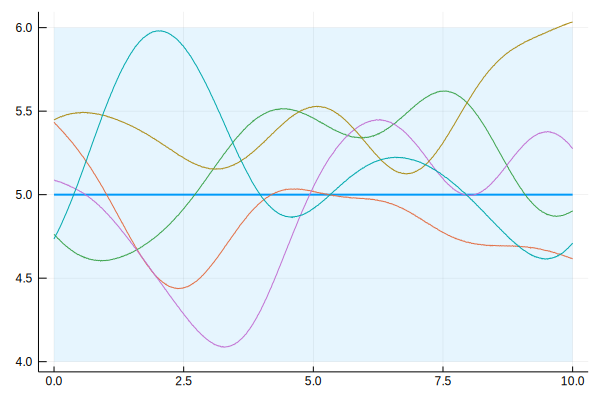

In [165]:
plot(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(prior_distribution.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(Xs, rand(prior_distribution, 5))

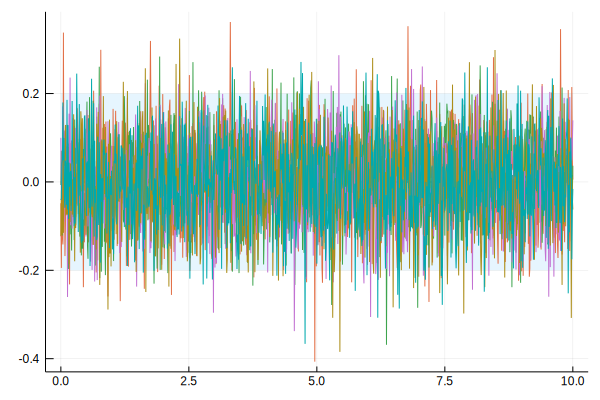

In [166]:
ϵ_dist = prior(ϵ, Xs)
plot(
    Xs, ϵ_dist.μ, 
    width=2, 
    ribbon=2sqrt.(diag(ϵ_dist.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(Xs, rand(ϵ_dist, 5))

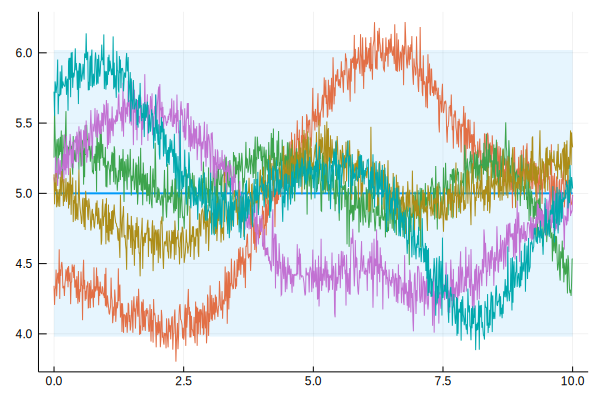

In [167]:
y_dist = prior(y, Xs)
plot(
    Xs, y_dist.μ, 
    width=2, 
    ribbon=2sqrt.(diag(y_dist.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(Xs, rand(y_dist, 5))

## Posterior Sample
First generate some evidence from a single GP sample.

Then condition the GP on this evidence and plot the mean, variance, and some samples from this conditioned GP.

In [168]:
gen_f, gen_ϵ = GP(constant_mean(-1.), rbf([0.5], [2])), GP(noise([0.05]))
gen_y = gen_f + gen_ϵ
n = 100
X = 1 .+ rand(n) * 8
gen_f_dist = prior(gen_f, Xs)
gen_ϵ_dist = prior(gen_ϵ, Xs)
idx = sample(1:length(Xs), n)
X = Xs[idx]
full_f = rand(gen_f_dist)
full_ϵ = rand(gen_ϵ_dist)
f_vect = full_f[idx]
ϵ_vect = full_ϵ[idx]
y = f_vect .+ ϵ_vect

100-element Array{Float64,1}:
  0.44608674045546043
 -1.031197665717226  
 -4.452579174918096  
 -4.022992262665739  
  0.7011601077782776 
 -4.206067027320075  
 -2.376177042259029  
 -3.5005883345605455 
 -0.14427875756971342
  1.5739970173633755 
 -0.74088606289733   
  0.12420985331269518
 -0.8344634751005985 
  ⋮                  
 -3.5822677888401264 
  0.6843654938357778 
 -1.580670260748964  
 -0.3460996747805603 
  1.643833382407904  
  0.8474698142781233 
 -0.5988326993104699 
 -1.0859740169678636 
 -1.0517396142346034 
 -2.389685686347347  
  1.0354572895084766 
 -0.12428317789540257

In [169]:
function posterior(gp, X, y, Xs) 
    Δy = y - gp.μ(X)
    
    K = gp.k(X, X)
    Ks = gp.k(X, Xs)
    Kss = gp.k(Xs, Xs)

    K_inv = inv(K + gp.σ_n[1].^2 * I + 1e-6*I)

    cov = Kss - Ks' * K_inv * Ks
    mean = Ks' * K_inv * Δy
    
    return MultivariateNormal(gp.μ(Xs) + mean, Symmetric(cov + 1e-6I))
end

posterior (generic function with 1 method)

In [170]:
posterior_distribution = posterior(f, X, y, Xs)

ErrorException: type GP has no field σ_n

In [171]:
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Prior GP"
)
plot!(
    Xs, posterior_distribution.μ, 
    ribbon=2(sqrt.(diag(posterior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.05, 
    label="",
    color=1
)
scatter!(X, y, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2generating_gp.σ_n, 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)

UndefVarError: UndefVarError: posterior_distribution not defined